In [418]:
%load_ext autoreload
%autoreload 2

import os, sys
# file_dir = os.path.dirname(__file__)
# sys.path.append(file_dir)
sys.path.append('/home/yz685/low_rank_BOPE')
sys.path.append('/home/yz685/low_rank_BOPE/low_rank_BOPE')
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import torch
from torch import Tensor

from test_problems.synthetic_problem import generate_principal_axes, PCATestProblem
from src.transforms import (
    generate_random_projection,
    InputCenter,
    LinearProjectionInputTransform,
    LinearProjectionOutcomeTransform,
    PCAInputTransform,
    PCAOutcomeTransform,
    SubsetOutcomeTransform,
)
from src.pref_learning_helpers import gen_initial_real_data, fit_pref_model
from src.diagnostics import check_util_model_fit
from src.models import make_modified_kernel

# import botorch, gpytorch functions
from botorch import fit_gpytorch_model, fit_gpytorch_mll
from botorch.optim.fit import fit_gpytorch_scipy
from botorch.optim.utils import _filter_kwargs
from botorch.utils.sampling import draw_sobol_samples
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import ChainedOutcomeTransform, Standardize
from botorch.models.transforms.input import (
    ChainedInputTransform,
    FilterFeatures,
    Normalize,
)

from gpytorch.kernels import MaternKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Overview

In this notebook, we generate synthetic metric data and test two modeling approaches, namely

- [baseline] fit a single-task GP to each metric
- [proposed] perform PCA on the metric data, and fit single-task GPs to the principal components (PCs)

## TL;DR: 
We use a toy example to show that using all the principal axes (same number as output space dimension) achieves a better model fit than fitting independent single-task GPs.

(Next steps would be to increase the dimensionality and use fewer principal axes.)

As a toy example, we work with a one-dimensional input space [0, 1] and two-dimensional output space (i.e., metric space). We fix two ground-truth principal axes and generate scalar PC values from two single-task GPs with different lengthscales, so that the first principal axis is more dominant.

In [4]:
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Try outcome dimensionality = 100, rank = 1

In [378]:
config = {
    "input_dim": 1,
    "outcome_dim": 100,
    "latent_dim": 1,
    "PC_noise_level": 0,
    "noise_std": 0.1,
    "num_initial_samples": 20,
    "num_sample_points": 30,
    "jitter": 0.00001,  # noqa
    "ground_truth_principal_axes": torch.Tensor([1]*100),
    "PC_lengthscales": [0.1],
    "PC_scaling_factors": [2],
    "variance_explained_threshold": 0.99,
}

torch.manual_seed(1234)

ground_truth_principal_axes = config['ground_truth_principal_axes'].unsqueeze(0)

initial_X = torch.randn((config["num_initial_samples"], config["input_dim"]), **tkwargs)

obj_indices = list(range(config["outcome_dim"]))
cons_indices = []

problem = PCATestProblem(
    opt_config=(obj_indices, cons_indices),
    initial_X=initial_X,
    bounds=torch.Tensor([[0, 1]] * config["input_dim"]),
    ground_truth_principal_axes=ground_truth_principal_axes,
    noise_std=config["noise_std"],
    PC_lengthscales=Tensor(config["PC_lengthscales"]),
    PC_scaling_factors=Tensor(config["PC_scaling_factors"]),
    dtype=torch.double,
)

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/botorch/test_functions/base.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "bounds", torch.tensor(self._bounds, dtype=torch.float).transpose(-1, -2)


In [174]:
class LinearUtil(torch.nn.Module):
    def __init__(self, beta: torch.Tensor):
        """
        Args:
            beta: size `output_dim` tensor
        """
        super().__init__()
        self.register_buffer("beta", beta)

    def calc_raw_util_per_dim(self, Y):
        return Y * self.beta.to(Y)

    def forward(self, Y, X=None):
        return Y @ self.beta.to(Y)

class SumOfSquaresUtil(torch.nn.Module):
    def __init__(self, beta: torch.Tensor):
        """
        Args:
            beta: size `output_dim` tensor
        """
        super().__init__()
        self.register_buffer("beta", beta)

    def calc_raw_util_per_dim(self, Y):
        return torch.square(Y) * self.beta.to(Y)

    def forward(self, Y, X=None):
        return torch.square(Y) @ self.beta.to(Y)

In [400]:
torch.manual_seed(123)

beta = torch.tensor([1]*config["outcome_dim"], **tkwargs)
util_func = LinearUtil(beta=beta)

train_X, train_Y, util_vals, comps = gen_initial_real_data(n=400, problem=problem, util_func=util_func)

# train_Y = train_Y - torch.mean(train_Y, dim = 0)

In [389]:
train_X.shape, train_Y.shape

(torch.Size([200, 1]), torch.Size([200, 100]))

In [401]:
st_model = SingleTaskGP(
    train_X,
    train_Y,
    covar_module = MaternKernel(lengthscale_prior = GammaPrior(3,6))
)
st_mll = ExactMarginalLogLikelihood(st_model.likelihood, st_model)
fit_gpytorch_model(st_mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
  )
)

In [402]:
options = {"maxiter": 1000}

pca_model = SingleTaskGP(
    train_X,
    train_Y,
    outcome_transform=ChainedOutcomeTransform(
        **{
            "standardize": Standardize(config["outcome_dim"], min_stdv=100),
            "pca": PCAOutcomeTransform(num_axes=1),
        }
    ),
    likelihood=GaussianLikelihood(noise_prior=GammaPrior(0.9, 10)),
)
pca_mll = ExactMarginalLogLikelihood(pca_model.likelihood, pca_model)

# train PCA model and log training stats
# fit_gpytorch_scipy(pca_mll, options=options)
fit_gpytorch_model(pca_mll)

print(pca_model.outcome_transform['pca'].axes_learned)

/home/yz685/low_rank_BOPE/low_rank_BOPE/src/transforms.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.axes_learned = torch.tensor(axes_learned, **tkwargs)


tensor([[0.1004, 0.0999, 0.0998, 0.0999, 0.1003, 0.1006, 0.0994, 0.0999, 0.1002,
         0.0994, 0.1002, 0.0998, 0.1000, 0.0996, 0.1001, 0.1003, 0.1002, 0.1001,
         0.1005, 0.0997, 0.0999, 0.1002, 0.0996, 0.1000, 0.0999, 0.1000, 0.0997,
         0.0998, 0.1007, 0.0997, 0.1004, 0.0998, 0.0996, 0.0994, 0.1002, 0.1004,
         0.0999, 0.0994, 0.0996, 0.1000, 0.0999, 0.1003, 0.1000, 0.1000, 0.1003,
         0.1004, 0.1000, 0.0999, 0.1000, 0.0998, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1003, 0.0997, 0.0995, 0.0997, 0.1003, 0.0997, 0.1003, 0.1003, 0.1002,
         0.0997, 0.0998, 0.0996, 0.1004, 0.1002, 0.0997, 0.1001, 0.1005, 0.0997,
         0.1003, 0.1002, 0.1000, 0.1005, 0.1001, 0.0998, 0.1005, 0.1001, 0.0998,
         0.1003, 0.1003, 0.1000, 0.0999, 0.1002, 0.0999, 0.0998, 0.1002, 0.1001,
         0.0993, 0.1000, 0.0999, 0.0998, 0.0999, 0.1001, 0.0997, 0.1003, 0.1001,
         0.0995]], dtype=torch.float64)


In [403]:
def helper(num_test_points, models_dict, outcome_idxs):

    test_X = torch.linspace(0, 1, num_test_points).unsqueeze(1).to(**tkwargs)
    test_Y = problem.eval_metrics_true(test_X).detach()

    for outcome_idx in outcome_idxs:

        for model_name, model in models_dict.items():

            test_Y_posterior_mean = model.posterior(test_X).mean[:, outcome_idx]
           
            print(model_name, 'outcome', outcome_idx, 'RMSE', torch.sqrt(torch.mean(torch.square(test_Y_posterior_mean - test_Y[:,outcome_idx]))).item())



In [404]:
helper(101, {"PCA": pca_model, "Indep": st_model}, [0,1,2,3,4,5,6,7,8,9])

PCA outcome 0 RMSE 0.008200884253910034
Indep outcome 0 RMSE 0.02727356707211266
PCA outcome 1 RMSE 0.004601200683056062
Indep outcome 1 RMSE 0.032524029869679234
PCA outcome 2 RMSE 0.00804417389306083
Indep outcome 2 RMSE 0.02730499678053859
PCA outcome 3 RMSE 0.004627929602129128
Indep outcome 3 RMSE 0.029218666175246405
PCA outcome 4 RMSE 0.006825502214449847
Indep outcome 4 RMSE 0.03586032176823077
PCA outcome 5 RMSE 0.011118594940917506
Indep outcome 5 RMSE 0.024080033162356018
PCA outcome 6 RMSE 0.013591836111516247
Indep outcome 6 RMSE 0.03410550885710688
PCA outcome 7 RMSE 0.007814374488643598
Indep outcome 7 RMSE 0.03339640597236642
PCA outcome 8 RMSE 0.005694089651069442
Indep outcome 8 RMSE 0.029611091609090073
PCA outcome 9 RMSE 0.011287635066612912
Indep outcome 9 RMSE 0.027949055749865837


In [405]:
pca_util_model = fit_pref_model(
    train_Y, 
    comps, 
    input_transform=ChainedInputTransform(
                    **{
                        "center": InputCenter(config["outcome_dim"]),
                        "pca": PCAInputTransform(pca_model.outcome_transform['pca'].axes_learned),
                    }
                ),
    covar_module = make_modified_kernel(ard_num_dims = 1)
)

pca_util_model_oracle = SingleTaskGP(
    train_Y, 
    util_vals.unsqueeze(1), 
    input_transform=ChainedInputTransform(
                    **{
                        "center": InputCenter(config["outcome_dim"]),
                        "pca": PCAInputTransform(pca_model.outcome_transform['pca'].axes_learned),
                    }
                ),
    covar_module = make_modified_kernel(ard_num_dims = 1)
)

mll = ExactMarginalLogLikelihood(pca_util_model_oracle.likelihood, pca_util_model_oracle)
fit_gpytorch_model(mll)

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): GreaterThan(1.000E-04)
      )
      (outputscale_prior): SmoothedBoxPrior()
      (raw_outputscale_constraint): Interval(2.000E-01, 5.000E+00)
    )
    (input_transform): ChainedInputTransform(
      (center): InputCenter()
      (pca): PCAInputTransform()
    )
  )
)

In [406]:
st_util_model = fit_pref_model(
    train_Y, 
    comps, 
    # input_transform=Normalize(config["outcome_dim"]),
    covar_module = make_modified_kernel(ard_num_dims = 100)
)

st_util_model_oracle = SingleTaskGP(
    train_Y, 
    util_vals.unsqueeze(1), 
    covar_module = make_modified_kernel(ard_num_dims = 100)
)

mll = ExactMarginalLogLikelihood(st_util_model_oracle.likelihood, st_util_model_oracle)
fit_gpytorch_model(mll)

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): GreaterThan(1.000E-04)
      )
      (outputscale_prior): SmoothedBoxPrior()
      (raw_outputscale_constraint): Interval(2.000E-01, 5.000E+00)
    )
  )
)

In [407]:
torch.manual_seed(0)
test_util_vals_pca, pred_util_vals_pca, util_acc_pca = check_util_model_fit(
    pref_model = pca_util_model,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('pca util accuracy: ', util_acc_pca)

test_util_vals_pca_oracle, pred_util_vals_pca_oracle, util_acc_pca_oracle = check_util_model_fit(
    pref_model = pca_util_model_oracle,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('pca oracle util accuracy: ', util_acc_pca_oracle)

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


pca util accuracy:  0.9980000257492065
pca oracle util accuracy:  0.9300000071525574


In [408]:
torch.manual_seed(0)
test_util_vals_st, pred_util_vals_st, util_acc_st = check_util_model_fit(
    pref_model = st_util_model,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('ST util accuracy: ', util_acc_st)

test_util_vals_st_oracle, pred_util_vals_st_oracle, util_acc_st_oracle = check_util_model_fit(
    pref_model = st_util_model_oracle,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('st oracle util accuracy: ', util_acc_st_oracle)

ST util accuracy:  0.9300000071525574
st oracle util accuracy:  0.8960000276565552


(array([205.,  80., 126., 141., 138.,  83.,  60.,  34.,  44.,  89.]),
 array([-141.55967544,  -76.80656582,  -12.05345621,   52.6996534 ,
         117.45276301,  182.20587262,  246.95898223,  311.71209184,
         376.46520145,  441.21831106,  505.97142067]),
 <BarContainer object of 10 artists>)

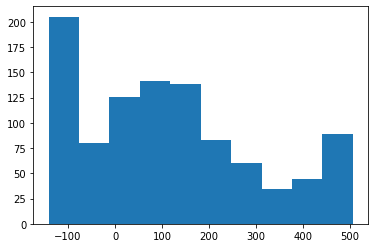

In [398]:
plt.hist(test_util_vals_st.detach().numpy())

Text(0.5, 1.0, 'difference in true test utility values')

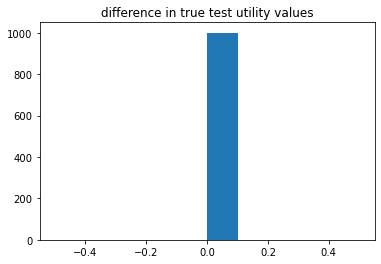

In [353]:
# can confirm that the test points are the same for PCA and ST 
plt.hist((test_util_vals_st - test_util_vals_pca).detach().numpy())
plt.title('difference in true test utility values')

Text(0.5, 1.0, 'difference in predicted test utility values')

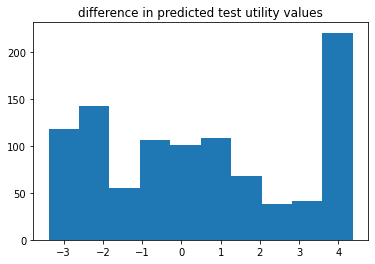

In [354]:
plt.hist((pred_util_vals_st - pred_util_vals_pca).detach().numpy())
plt.title('difference in predicted test utility values')

mean difference in relative error of utility prediction -0.0004703336967288416
SD of difference in relative error of utility prediction 0.6295576221525078


Text(0.5, 1.0, 'difference in relative error of predicted test utility values')

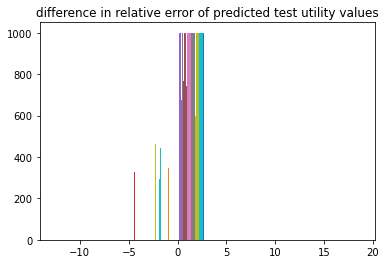

In [409]:
print(
    'mean difference in relative error of utility prediction', 
    torch.mean((pred_util_vals_st_oracle - pred_util_vals_pca_oracle)/test_util_vals_st).item()
)

print(
    'SD of difference in relative error of utility prediction', 
    torch.std((pred_util_vals_st_oracle - pred_util_vals_pca_oracle)/test_util_vals_st).item()
)

plt.hist(((pred_util_vals_st_oracle - pred_util_vals_pca_oracle)/test_util_vals_st).detach().numpy())
plt.title('difference in relative error of predicted test utility values')

In [ ]:
# Next TODO:

# look at nonlinear utility
# math derivation

# Try outcome dimensionality = 20, rank = 1

In [438]:
config = {
    "input_dim": 1,
    "outcome_dim": 20,
    "latent_dim": 1,
    "PC_noise_level": 0,
    "noise_std": 0.1,
    "num_initial_samples": 20,
    "num_sample_points": 30,
    "jitter": 0.00001,  # noqa
    "ground_truth_principal_axes": torch.Tensor([1]*20),
    "PC_lengthscales": [0.1],
    "PC_scaling_factors": [2],
    "variance_explained_threshold": 0.99,
}

torch.manual_seed(1234)

ground_truth_principal_axes = config['ground_truth_principal_axes'].unsqueeze(0)

initial_X = torch.randn((config["num_initial_samples"], config["input_dim"]), **tkwargs)

obj_indices = list(range(config["outcome_dim"]))
cons_indices = []

problem = PCATestProblem(
    opt_config=(obj_indices, cons_indices),
    initial_X=initial_X,
    bounds=torch.Tensor([[0, 1]] * config["input_dim"]),
    ground_truth_principal_axes=ground_truth_principal_axes,
    noise_std=config["noise_std"],
    PC_lengthscales=Tensor(config["PC_lengthscales"]),
    PC_scaling_factors=Tensor(config["PC_scaling_factors"]),
    dtype=torch.double,
)

use_modified_kernel = False

In [439]:
torch.manual_seed(123)

beta = torch.tensor([1]*config["outcome_dim"], **tkwargs)
util_func = LinearUtil(beta=beta)

train_X, train_Y, util_vals, comps = gen_initial_real_data(n=100, problem=problem, util_func=util_func)


In [440]:
train_Y.shape, util_vals.shape, comps.shape

(torch.Size([100, 20]), torch.Size([100]), torch.Size([50, 2]))

In [441]:
st_model_low = SingleTaskGP(
    train_X,
    train_Y,
    covar_module = MaternKernel(lengthscale_prior = GammaPrior(3,6))
)
st_mll_low = ExactMarginalLogLikelihood(st_model_low.likelihood, st_model_low)
fit_gpytorch_mll(st_mll_low)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
  )
)

In [442]:
options = {"maxiter": 1000}

pca_model_low = SingleTaskGP(
    train_X,
    train_Y,
    outcome_transform=ChainedOutcomeTransform(
        **{
            "standardize": Standardize(config["outcome_dim"], min_stdv=100),
            "pca": PCAOutcomeTransform(num_axes=1),
        }
    ),
    likelihood=GaussianLikelihood(noise_prior=GammaPrior(0.9, 10)),
)
pca_mll_low = ExactMarginalLogLikelihood(pca_model_low.likelihood, pca_model_low)

# train PCA model and log training stats
# fit_gpytorch_scipy(pca_mll, options=options)
fit_gpytorch_mll(pca_mll_low)

print(pca_model_low.outcome_transform['pca'].axes_learned)

tensor([[0.2239, 0.2215, 0.2233, 0.2244, 0.2242, 0.2232, 0.2233, 0.2231, 0.2243,
         0.2244, 0.2222, 0.2231, 0.2247, 0.2244, 0.2236, 0.2227, 0.2239, 0.2237,
         0.2233, 0.2247]], dtype=torch.float64)


In [443]:
use_modified_kernel = True

pca_covar_module = None
if use_modified_kernel:
    pca_covar_module = make_modified_kernel(ard_num_dims = 1)


pca_util_model = fit_pref_model(
    train_Y, 
    comps, 
    input_transform=ChainedInputTransform(
                    **{
                        "center": InputCenter(config["outcome_dim"]),
                        "pca": PCAInputTransform(pca_model_low.outcome_transform['pca'].axes_learned),
                    }
                ),
    covar_module = pca_covar_module
)

pca_util_model_oracle = SingleTaskGP(
    train_Y, 
    util_vals.unsqueeze(1), 
    input_transform=ChainedInputTransform(
                    **{
                        "center": InputCenter(config["outcome_dim"]),
                        "pca": PCAInputTransform(pca_model_low.outcome_transform['pca'].axes_learned),
                    }
                ),
    covar_module = pca_covar_module
)

mll = ExactMarginalLogLikelihood(pca_util_model_oracle.likelihood, pca_util_model_oracle)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): GreaterThan(1.000E-04)
      )
      (outputscale_prior): SmoothedBoxPrior()
      (raw_outputscale_constraint): Interval(2.000E-01, 5.000E+00)
    )
    (input_transform): ChainedInputTransform(
      (center): InputCenter()
      (pca): PCAInputTransform()
    )
  )
)

In [450]:
use_modified_kernel = True

st_covar_module = None
if use_modified_kernel:
    st_covar_module = make_modified_kernel(ard_num_dims = 20)

st_util_model = fit_pref_model(
    train_Y, 
    comps, 
    # input_transform=Normalize(config["outcome_dim"])
    covar_module = st_covar_module
)

st_util_model_oracle = SingleTaskGP(
    train_Y, 
    util_vals.unsqueeze(1), 
    covar_module = st_covar_module
)

mll = ExactMarginalLogLikelihood(st_util_model_oracle.likelihood, st_util_model_oracle)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): GreaterThan(1.000E-04)
      )
      (outputscale_prior): SmoothedBoxPrior()
      (raw_outputscale_constraint): Interval(2.000E-01, 5.000E+00)
    )
  )
)

In [448]:
torch.manual_seed(0)
test_util_vals_pca, pred_util_vals_pca, util_acc_pca = check_util_model_fit(
    pref_model = pca_util_model,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('pca util accuracy: ', util_acc_pca)

test_util_vals_pca_oracle, pred_util_vals_pca_oracle, util_acc_pca_oracle = check_util_model_fit(
    pref_model = pca_util_model_oracle,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('pca oracle util accuracy: ', util_acc_pca_oracle)

pca util accuracy:  0.9660000205039978
pca oracle util accuracy:  0.9380000233650208


In [451]:
torch.manual_seed(0)
test_util_vals_st, pred_util_vals_st, util_acc_st = check_util_model_fit(
    pref_model = st_util_model,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('ST util accuracy: ', util_acc_st)

test_util_vals_st_oracle, pred_util_vals_st_oracle, util_acc_st_oracle = check_util_model_fit(
    pref_model = st_util_model_oracle,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('st oracle util accuracy: ', util_acc_st_oracle)

NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.

mean difference in relative error of utility prediction -0.005132338271812821
SD of difference in relative error of utility prediction 1.5979983156094808


Text(0.5, 1.0, 'difference in relative error of predicted test utility values')

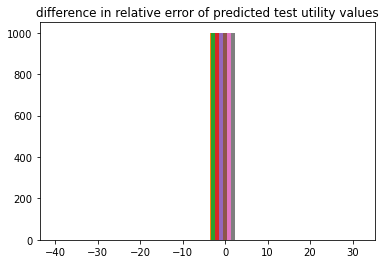

In [377]:
print(
    'mean difference in relative error of utility prediction', 
    torch.mean((pred_util_vals_st_oracle - pred_util_vals_pca_oracle)/test_util_vals_st).item()
)

print(
    'SD of difference in relative error of utility prediction', 
    torch.std((pred_util_vals_st_oracle - pred_util_vals_pca_oracle)/test_util_vals_st).item()
)

plt.hist(((pred_util_vals_st_oracle - pred_util_vals_pca_oracle)/test_util_vals_st).detach().numpy())
plt.title('difference in relative error of predicted test utility values')